In [1]:
import pandas as pd

# Load the dataset
file_path = 'Movies_new_FTD_preprocessed.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure and contents
data.head()


,budget,genres,original_language,popularity,production_companies,production_countries,revenue,runtime,title,vote_average,vote_count,cast,release_year,release_month,release_day,Profit,roi
0,200000000,7,4,37.668301,1,141,310669540,140.0,Robin Hood,6.2,1398,1,2010,5,12,110669540,55.334770
1,180000000,3,4,42.990906,1,141,372234864,113.0,The Golden Compass,5.8,1303,1,2007,12,4,192234864,106.797147
2,150000000,9,4,21.939663,1,2086,836297228,150.0,Transformers: Revenge of the Fallen,6.0,3138,1,2009,6,19,686297228,457.531485
3,170000000,13,4,73.795050,1,2086,400062763,125.0,TRON: Legacy,6.3,2841,1,2010,12,10,230062763,135.331037
4,200000000,2,4,49.986590,11,2086,559852396,106.0,Cars 2,5.8,2033,1,2011,6,11,359852396,179.926198


In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Preparing the original dataset
# For machine learning, we usually need to remove non-numeric columns like 'title'
original_dataset = data.drop(columns=['title'])

# Standardizing the data for PCA
# It's important to standardize the data before applying PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(original_dataset)

# Applying PCA
# Let's retain 95% of the variance in the dataset
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(scaled_data)

# Creating a DataFrame for the PCA data
pca_columns = [f'PC{i+1}' for i in range(pca_data.shape[1])]
pca_dataset = pd.DataFrame(pca_data, columns=pca_columns)

# Feature-Selected Dataset
# Selecting features based on common sense - let's choose budget, popularity, vote_average, and runtime for now
selected_features = ['budget', 'popularity', 'vote_average', 'runtime']
feature_selected_dataset = data[selected_features]

original_dataset.head(), pca_dataset.head(), feature_selected_dataset.head()


(      budget  genres  original_language  popularity  production_companies  \
 0  200000000       7                  4   37.668301                     1   
 1  180000000       3                  4   42.990906                     1   
 2  150000000       9                  4   21.939663                     1   
 3  170000000      13                  4   73.795050                     1   
 4  200000000       2                  4   49.986590                    11   
 
    production_countries    revenue  runtime  vote_average  vote_count  cast  \
 0                   141  310669540    140.0           6.2        1398     1   
 1                   141  372234864    113.0           5.8        1303     1   
 2                  2086  836297228    150.0           6.0        3138     1   
 3                  2086  400062763    125.0           6.3        2841     1   
 4                  2086  559852396    106.0           5.8        2033     1   
 
    release_year  release_month  release_day    

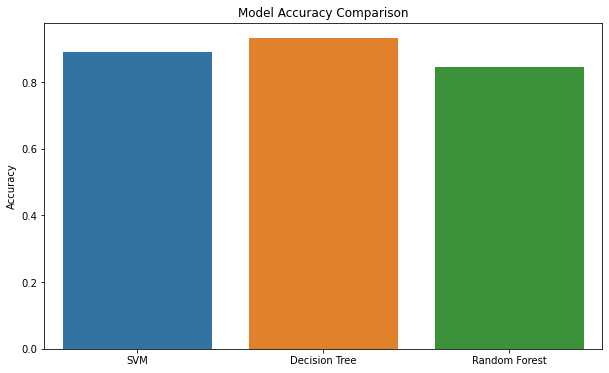

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Creating classification labels based on ROI
def classify_roi(roi):
    if roi < 100:
        return 'Failure'
    elif roi < 200:
        return 'Passable'
    else:
        return 'Success'

data['roi_class'] = data['roi'].apply(classify_roi)

# Splitting the data into features and target
X = original_dataset.drop(columns=['roi', 'Profit'])  # Removing 'roi' and 'Profit' as they directly influence the target
y = data['roi_class']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Defining the models
models = {
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Training and evaluating the models
accuracy_results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)

# Since we are using only one dataset for now, we will create a simple bar chart for accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(models.keys()), y=accuracy_results)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()


/var/folders/j2/d6gfnc_j1w92nhthf02vfpy00000gn/T/ipykernel_65850/4224735765.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_selected_dataset['roi_class'] = data['roi_class']


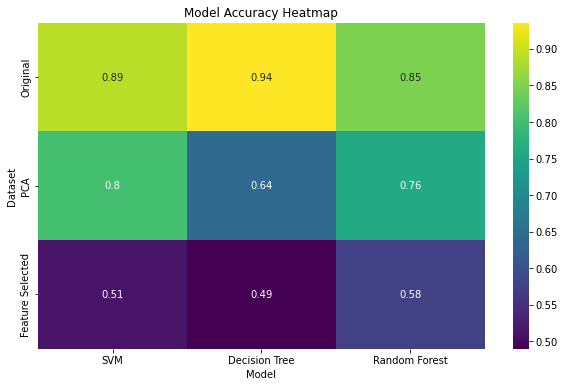

In [4]:
# Preparing the PCA dataset and Feature-Selected dataset for model training
# We need to add the roi_class column to these datasets
pca_dataset['roi_class'] = data['roi_class']
feature_selected_dataset['roi_class'] = data['roi_class']

# Splitting the datasets
X_pca = pca_dataset.drop(columns=['roi_class'])
y_pca = pca_dataset['roi_class']
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y_pca, test_size=0.3, random_state=42)

X_feature_selected = feature_selected_dataset.drop(columns=['roi_class'])
y_feature_selected = feature_selected_dataset['roi_class']
X_feature_selected_train, X_feature_selected_test, y_feature_selected_train, y_feature_selected_test = train_test_split(X_feature_selected, y_feature_selected, test_size=0.3, random_state=42)

# Training and evaluating the models on all datasets
datasets = {
    'Original': (X_train, X_test, y_train, y_test),
    'PCA': (X_pca_train, X_pca_test, y_pca_train, y_pca_test),
    'Feature Selected': (X_feature_selected_train, X_feature_selected_test, y_feature_selected_train, y_feature_selected_test)
}

accuracy_matrix = []

for dataset_name, (X_tr, X_te, y_tr, y_te) in datasets.items():
    accuracies = []
    for model_name, model in models.items():
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        accuracy = accuracy_score(y_te, y_pred)
        accuracies.append(accuracy)
    accuracy_matrix.append(accuracies)

# Creating the accuracy heatmap
accuracy_df = pd.DataFrame(accuracy_matrix, columns=models.keys(), index=datasets.keys())

plt.figure(figsize=(10, 6))
sns.heatmap(accuracy_df, annot=True, cmap='viridis')
plt.title('Model Accuracy Heatmap')
plt.xlabel('Model')
plt.ylabel('Dataset')
plt.show()
